# Домашнее задание №2 - Линейные модели. Градиентный спуск

В этом домашнем задании мы с вами научимся обучать линейные модели регрессии и классификации при помощи очень мощного, но в то же время довольно понятного алгоритма, который называется **градиетный спуск**. Помимо линейных моделей он используется и для обучения самых сложных нейронных сетей! Также мы потренируемся применять готовые реализации линейных моделей для задач регрессии и бинарной классификации.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import pandas as pd
import math

from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from sklearn.exceptions import NotFittedError
from sklearn.linear_model import (LinearRegression,
                                  LogisticRegression)
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.datasets import make_classification
from sklearn.metrics import (r2_score,
                             mean_squared_error)
from sklearn.model_selection import train_test_split

In [2]:
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

#### Маленькое теоретическое отступление

Основное свойство антиградиента (-1 * градиент) &ndash; он указывает в сторону наискорейшего убывания функции в данной точке. Соответственно, будет логично стартовать из некоторой точки, сдвинуться в сторону антиградиента, пересчитать антиградиент и снова сдвинуться в его сторону и т.д. Запишем это более формально.

Пусть $w_0$ &ndash; начальный набор параметров (коэффициентов линейной модели) ((например, нулевой или сгенерированный из некоторого, случайного распределения)). Тогда обычный градиентный спуск состоит в повторении следующих шагов до сходимости:


$$
    w_{k + 1} = w_{k} - \eta \nabla_{w} Q(w_{k}),
$$

где $\nabla_{w} Q(w_{k})$ &ndash; градиент функции потерь в точке $w_k$, а $\eta$ &ndash; скорость обучения (learning rate).

Градиентный спуск обычно останавливают, когда прошло заданное максимальное количество итераций или когда графиент близок к нулю (т.е. наши параметры практически не меняются). Для реализации второго варианта считают норму градиента (по сути длину вектора). Это можно сделать несколькими способами:

$$
l1_{norm} = \sum{|w_i|}
$$

$$
l2_{norm} = \sum{(w_i)^{2}}
$$

Попробуем разобраться на простом примере. Рассмотрим функцию от двух переменных:
$f(x, y) = \sin^2 x + \sin^2 y$

In [3]:
def f(w):
    """
    :param w: np.array(np.float) вектор из 2-х элементов
    :return: np.float
    """
    
    return np.sum(np.sin(w)**2)

Обратите внимание, что $x$ - numpy-array вектор длины 2.

***Reminder:***  
Что мы хотим? Мы хотим найти минимум этой функции (в машинном обучении мы обычно хотим найти минимум **функции потерь**, например, MSE), а точнее найти $w_1$ и $w_2$ такие, что при них значение $f(w_1, w_2)$ минимально, то есть *точку экстремума*.  
  
Как мы будем искать эту точку? Используем методы оптимизации (в нашем случае - *минимизации*). Одним из таких методов и является **градиентный спуск**.

### Задание 1. Градиентный спуск для функции $f$ (1 балл)

Реализуйте функцию, которая будет осуществлять градиентный спуск для функции $f$:

*Примечание:* Вам нужно посчитать частные производные именно **аналитически** и **переписать их в код**, а не считать производные численно (через отношение приращения функции к приращению аргумента) -- в этих двух случаях могут различаться ответы, поэтому будьте внимательны.

In [4]:
def grad_f(w): 
    """
    Градиент функциии f, определенной выше.
        :param w: np.array[2]: float вектор из 2-х элементов
        :return: np.array[2]: float вектор из 2-х элементов
    """
    dx = 2 * math.sin(w[0]) * math.cos(w[0])
    dy = 2 * math.sin(w[1]) * math.cos(w[1])
    return np.array([dx, dy])

Проверим, что градиент принимает вектор из двух чисел и выдает на этой точке верное значение

In [5]:
assert np.allclose(grad_f(np.array([1, 2])), 
                   np.array([0.90929743, -0.7568025])), "Что-то не так!"

In [6]:
def grad_descent_2d(f, grad_f, lr, num_iter=100, x0=None):
    """
    Функция, которая реализует градиентный спуск в минимум для функции f от двух переменных. 
        :param f: скалярная функция двух переменных
        :param grad_f: функция, возвращающая градиент функции f (устроена как реализованная вами выше grad_f)
        :param lr: learning rate алгоритма
        :param num_iter: количество итераций градиентного спуска
        :return: np.array[num_iter, 2] пар вида (x, f(x))
    """
    
    w0 = np.random.random(2)

    # будем сохранять значения аргументов и значений функции 
    # в процессе град. спуска в переменную history
    history = []

    # итерация цикла == шаг градиентнго спуска
    curr_w = w0.copy()
    for iter_num in range(num_iter):
        entry = np.hstack((curr_w, f(curr_w)))
        history.append(entry)
    
        curr_w -= lr*grad_f(curr_w)

    return np.vstack(history)

Визуализируем точки градиентного спуска на 3D-графике нашей функции. Звездочками будут обозначены точки (тройки $w_1, w_2, f(w_1, w_2)$), по которым Ваш алгоритм градиентного спуска двигался к минимуму (Для того, чтобы написовать этот график, мы и сохраняли значения $cur\_w_1, cur\_w_2, f(cur\_w_1, cur\_w_2)$ в `steps` в процессе спуска).

Если у Вас правильно написана функция `grad_descent_2d`, то звездочки на картинке должны сходиться к одной из точек минимума функции. Вы можете менять начальные приближения алгоритма, значения `lr` и `num_iter` и получать разные результаты.

In [7]:
def gradient_desc_vis(f, grad_f, lr=0.1, num_iter=20):
    steps = grad_descent_2d(f, grad_f, lr=lr, num_iter=num_iter)
    
    X, Y = np.meshgrid(np.linspace(-3, 3, 100), np.linspace(-3, 3, 100))

    fig = plt.figure(figsize=(16, 10))
    ax = fig.add_subplot(projection="3d")

    zs = np.array([f(np.array([x,y]))
                  for x, y in zip(np.ravel(X), np.ravel(Y))])
    Z = zs.reshape(X.shape)


    ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, zorder=2)

    ax.plot(xs=steps[:, 0], ys=steps[:, 1], zs=steps[:, 2],
            marker="*", markersize=20, zorder=3, 
            markerfacecolor="y", lw=3, c="black")

    ax.set_zlim(0, 5)
    ax.view_init(elev=60)
    plt.show()
    
    return steps

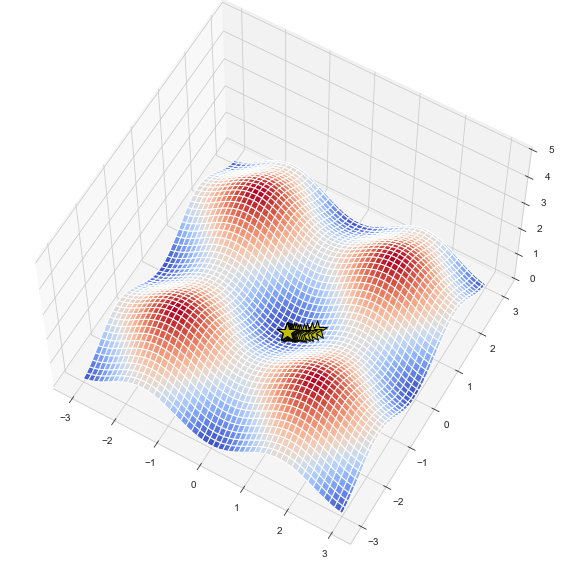

In [8]:
steps = gradient_desc_vis(f, grad_f)

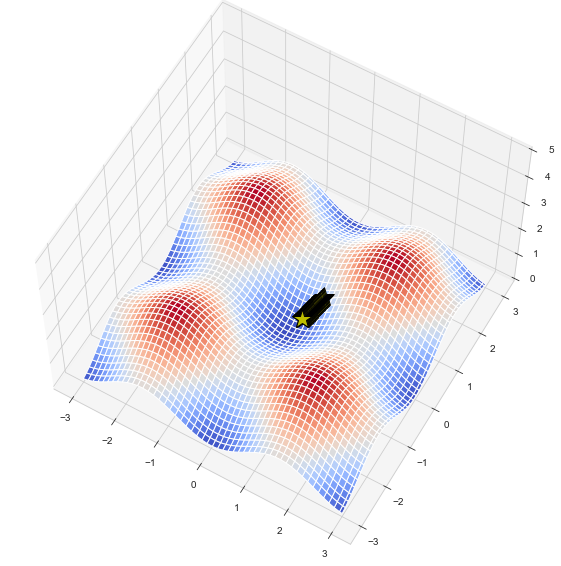

In [29]:
steps = gradient_desc_vis(f, grad_f, 0.01, 50)

Посмотрим на зависимость значения функции от шага градиентного спуска.

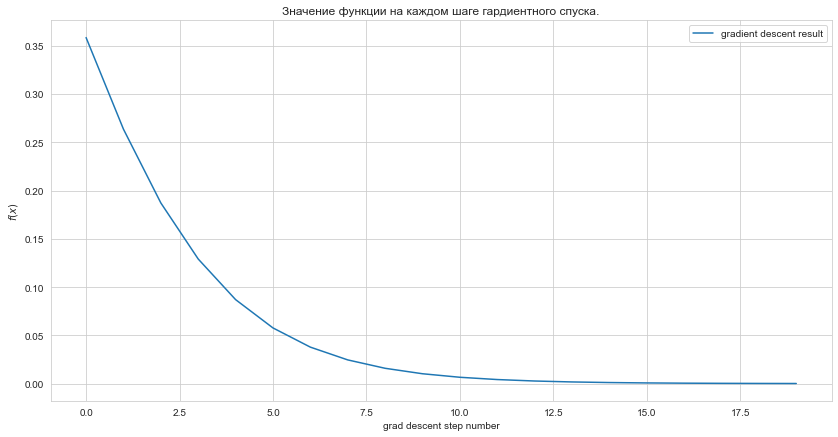

In [9]:
plt.figure(figsize=(14,7))
plt.xlabel("grad descent step number")
plt.ylabel("$f(x)$")
plt.title("Значение функции на каждом шаге гардиентного спуска.")

f_values = list(map(lambda x: x[2], steps))
plt.plot(f_values, label="gradient descent result")
plt.legend();

### Задание 2. Реализация линейной регресии (суммарно 9 баллов)

Так как мы будем использовать градиентный спуск для обучения модели, важной часть является реализация функции потерь и функции для расчета ее градиента. Перем началом стоит напомнить, как считать градиент MSE. Вывод этой формулы можно найти  [здесь](https://medium.com/analytics-vidhya/linear-regression-gradient-descent-intuition-and-math-c9a8f5aeeb22)

$$
    MSE = \frac{1}{N}\sum(y_{true} - y_{pred}) ^ 2
$$

$$
    \nabla{MSE} = \frac{2}{N} X^T (y_{pred} - y_{true})
$$

Здесь имеется в виду именно матричное умножение.

#### Задание 2.1. MSE и ее градиент (2 балла)

In [10]:
def mse(y_true, y_pred):
    """
    Функция потерь MSE.
        :param y_true: np.array[n_samples]: вектор из правильных ответов
        :param y_pred: np.array[n_samples]: вектор из предсказаний модели
        :return: значение функции потерь
    """
    
    if  y_true.shape[0] != y_pred.shape[0]:
        raise ValueError("Number of samples in both vectors should be equal")
        
    return np.square(y_true - y_pred) / y_true.shape[0]


def mse_grad(y_true, y_pred, X):
    """
    Функция для расчета градиента MSE.
        :param y_true: np.array[n_samples]: вектор из правильных ответов
        :param y_pred: np.array[n_samples]: вектор из предсказаний модели
        :param X: np.array[n_samples, n_features]: матрица объекты x признаки
        :return: градиент функции потерь MSE
    """
    
    if  y_true.shape[0] != y_pred.shape[0]:
        raise ValueError("Number of samples in both vectors should be equal")
        
    return (np.transpose(X) @ (y_pred - y_true)) * 2 / y_true.shape[0] 


class MSELoss:
    """
    Класс, реализующий функцию потерь MSE. Нужен для того, чтобы
    объединять в одном месте функцию потерь и градиент для нее.
    """
    
    def __call__(self, y_true, y_pred):
        return mse(y_true, y_pred)
    
    def calculate_gradient(self, y_true, y_pred, X):
        return mse_grad(y_true, y_pred, X)

Мы будем использовать следующий класс для расчета градиента наших функций потерь:

In [11]:
class BasicGradientDescent:
    """
    Класс, позволяющий делать шаги градиентного спуска,
    а также рассчитывающих норму градиента.
    """
    
    def __init__(self, loss_function, grad_norm):
        self.loss = loss_function
        self.grad_norm = grad_norm
        
    
    def step(self, y, y_pred, X):
        grad_i = self.loss.calculate_gradient(y, y_pred, X)
        grad_i_norm = self._calculate_grad_norm(grad_i)
        
        return grad_i, grad_i_norm
            
            
    def _calculate_grad_norm(self, grad_i):
        if self.grad_norm == "l1":
            return np.abs(grad_i).sum()
        elif self.grad_norm == "l2":
            return np.sqrt(np.square(grad_i).sum())
        else:
            raise ValueError(f"I can't calculate {self.grad_norm} norm of gradient")

В данном задании нужно будет реализовать линейную регрессию и обучить ее при помощи градиентного спуска. Для этого нужно будет заполнять пропуски кода в соответствующих классах. Для начала мы реализуем базовый класс для всех линейных моделей, от которого потом будем наследоваться при реализации линейной и логистической регресий. Не переживайте, этот класс уже реализован, вам достостаточно просто разобраться с кодом.

In [95]:
class BaseLinearModel:
    """
    Класс, который представляет из себя базовую линейную модель, наследуюясь от которого, мы будем
    реализовывать линейную и логистическую регрессии.
    """
    
    def __init__(self, learning_rate, 
                 loss_function, fit_intercept,
                 n_iter, tol, optimizer, grad_norm):
        """
        Конструктор нашего класса. 
            :param learning_rate: скорость обучения
            :param loss_function: функция потерь (MSE или кросс-энтропия)
            :param fit_intercept: нужно ли нам включать свободный член в модель
            :param n_iter: количество итераций градиентного спуска
            :param tol: параметр для остановки градиентного спуска,
                        если норма градиента (l1 или l2) меньше tol, то останавливаемся
            :param optimizer: класс, который будет рассчитывать градиент и его норму
            :param grad_norm: тип нормы градиента l1 или l2
        """
        
        self.learning_rate = learning_rate
        self.loss = loss_function
        self.fit_intercept = fit_intercept
        self.n_iter = n_iter
        self.tol = tol
        self.grad_norm = grad_norm
        self.optimizer = optimizer(loss_function, grad_norm)
        
        # В начале параметры модели не заданы
        self.W = None
        
        
    def fit(self, X, y):
        """
        Метод для обучения нашей модели 
            :param X: матрица объекты x признаки
            :param y: вектор значений целевой переменной
            :return: обученная модель
        """
        
        # Сделаем из y вектор-столбец (n_samples, 1)
        y = y.reshape(-1, 1)
        n_samples = X.shape[0]
        
        # Добавим колонку из 1 в матрицу X
        if self.fit_intercept:
            ones_column = np.ones((n_samples, 1))
            X_new = np.hstack((ones_column, X))
        
        n_features = X_new.shape[1]

        # Инициализируем веса модели
        if self.W is None:
            self.W = np.random.randn(n_features, 1)
        
        # Обучаем модель градиентным спуском
        for i in range(self.n_iter):
            y_pred = self.predict(X)
            grad_i, grad_i_norm = self.optimizer.step(y, y_pred, X_new)
            
            # Если градиент близок к 0, останавливаемся
            if grad_i_norm <= self.tol:
                return self
            
            else:
                self.W -= self.learning_rate * grad_i
        
        return self
    
    
    def predict(self, X):
        raise NotImplementedError("It is a basic class for all linear models. You should implement it for descendant class.")
    
    
    def __repr__(self):
        return "Base linear model without prediction skill :("

#### Задание 2.2. Предсказания линейной регрессии (3 балла)

Реализуйте метод `predict` у класса `CustomLinearRegression`, не забудьте про свободный член!

In [49]:
class CustomLinearRegression(BaseLinearModel):
    def __init__(self, learning_rate: float = 1e-2, 
                 loss_function=MSELoss(), fit_intercept=True,
                 n_iter=1000, tol=1e-5, optimizer=BasicGradientDescent, grad_norm="l1"):
        
        # Если вы не проходили наследование и в частности `super`, то не страшно
        # коротко, с помощью этого мы можем вызывать методы родительского класса
        # в частности здесь мы используем метод `init`
        super().__init__(learning_rate=learning_rate, 
                         loss_function=loss_function, fit_intercept=fit_intercept,
                         n_iter=n_iter, tol=tol, optimizer=optimizer, grad_norm=grad_norm)
        
    
    def predict(self, X_test):
        """
        Метод для вычисления предсказаний 
            :param X_test: np.array[n_test_samples, n_features]: 
                           матрица объекты x признаки (тестовый датасет)
            :return: y_pred: np.array[n_test_samples, 1]: предсказания модели
        """
        
        if self.W is None:
            raise NotFittedError("This CustomLinearRegression instance is not fitted yet, run fit method.")
        
        n_test_samples = X_test.shape[0]
        if self.fit_intercept:
            ones_column = np.ones((n_test_samples, 1))
            X_test = np.hstack((ones_column, X_test))
            
        return X_test @ self.W
    
    
    def __repr__(self):
        return "My custom linear regression"

##### Проверим нашу реализацию на простом примере

In [14]:
X = np.random.randn(100, 1)
y = 2 * X + 5 + 0.5 * np.random.randn(100, 1)

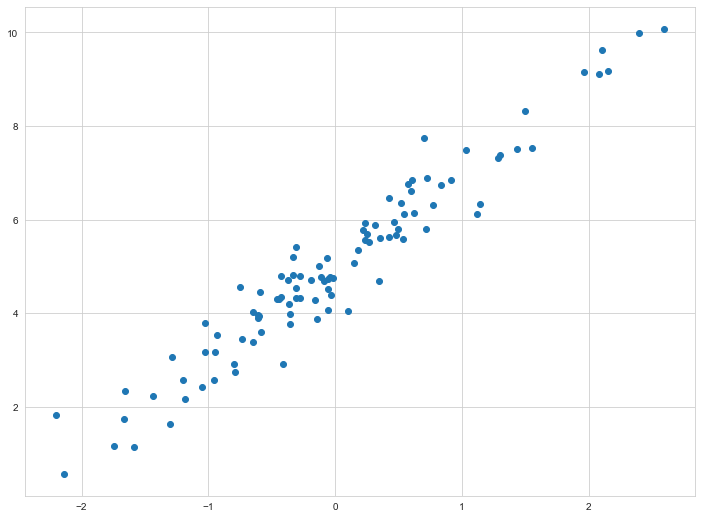

In [15]:
plt.scatter(X, y);

In [16]:
custom_lin_reg = CustomLinearRegression()

In [17]:
custom_lin_reg.fit(X, y)

My custom linear regression

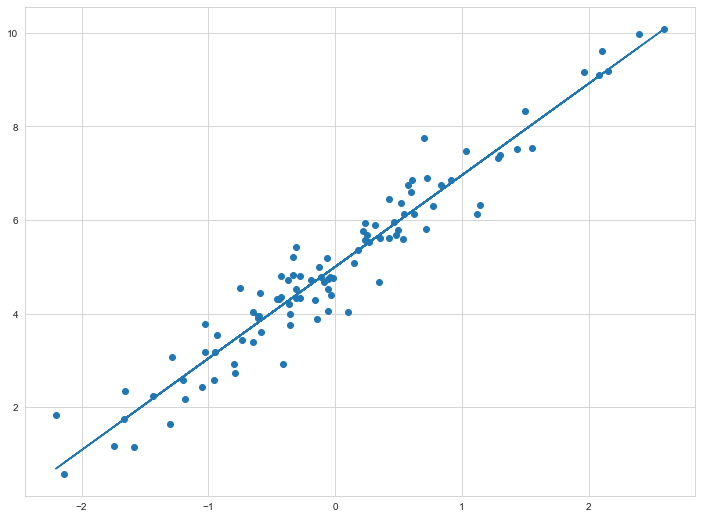

In [18]:
plt.scatter(X, y)
plt.plot(X, custom_lin_reg.predict(X));

#### Задание 2.3. Используем встроенную линейную регрессию (4 балла)

Поработаем с данными о ценах на дома в Калифорнии. Постройте модель линейной регресии при помощи `LinearRegression` из `sklearn`. Не забудьте разделить данные на тренировочную и тестовую части, а также правильно предобработать признаки. В конце воспользуйтесь какими-то изученными метриками регресии и сделайте выводы о качестве полученной модели, а также о том, какие признаки наиболее важны с точки зрения полученной модели.

In [19]:
data = fetch_california_housing()
X, y = data["data"], data["target"]
feature_names = data["feature_names"]

Ваш ход:

In [20]:
X_df = pd.DataFrame(X)
X_df.head()

,0,1,2,3,4,5,6,7
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [21]:
X_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 8 columns):
0    20640 non-null float64
1    20640 non-null float64
2    20640 non-null float64
3    20640 non-null float64
4    20640 non-null float64
5    20640 non-null float64
6    20640 non-null float64
7    20640 non-null float64
dtypes: float64(8)
memory usage: 1.3 MB


In [22]:
X_df.std()

0       1.899822
1      12.585558
2       2.474173
3       0.473911
4    1132.462122
5      10.386050
6       2.135952
7       2.003532
dtype: float64

Требуется стандартизация численных признаков

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [24]:
linear_regression_pipeline = Pipeline(steps=[
    ("standart scaler", StandardScaler()),
    ("linear regression", LinearRegression())
    ])
linear_regression_pipeline.fit(X_train, y_train)

Pipeline(steps=[('standart scaler', StandardScaler()),
                ('linear regression', LinearRegression())])

In [25]:
y_pred = linear_regression_pipeline.predict(X_test)

In [26]:
r2_score(y_test, y_pred), mean_squared_error(y_test, y_pred)

(0.5871060094335904, 0.5498727561680754)

В целом качество неплохое, хотя я не очень понимаю, как это оценить. $R^2$ довольно близко к 1, mse довольно близко к 0.

#### Оценка важности признаков

In [27]:
from sklearn.inspection import permutation_importance
r = permutation_importance(linear_regression_pipeline, X_test, y_test,
                            n_repeats=30,
                            random_state=0)

for i in r.importances_mean.argsort()[::-1]:
     if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
            print(f"{data.feature_names[i]:<8} \t"
              f"{r.importances_mean[i]:.3f}"
              f" +/- {r.importances_std[i]:.3f}")

Latitude 	1.297 +/- 0.038
Longitude 	1.125 +/- 0.038
MedInc   	1.000 +/- 0.028
AveBedrms 	0.062 +/- 0.004
AveRooms 	0.054 +/- 0.004
HouseAge 	0.020 +/- 0.002
AveOccup 	0.001 +/- 0.000


Широта и долгота - самые важные признаки, а среднее количество членов домохозяйства практически не имеет значения.

### Задание 3. Реализация логистической регресии (суммарно 10 баллов)

Логистическая регрессия не очень сильно отличается от обычной линейной регрессии и используется в задачах классификации. Так как здесь мы снова будем пользоваться градиентным спуском, то нужно определить функцию потерь и ее градиент. Одним из самых популярных вариантов в задаче бинарной классификации является бинарная кросс-энтропия (BCE).

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Единственная проблема данной функции это возможность получить 0 под знаком логарифма, что не очень хорошо. Попробуем справиться с этим "в лоб". Скажем, что наши предсказания могут принимать значения от 0 + eps до 1 - eps, где eps очень маленькое число.

#### Задание 3.1. Реализация сигмоиды (0.5 баллов)

Реализуйте функцию `sigmoid`, которая переводит действительное число $\mathbb R$ в вероятность $[0,1]$.

In [36]:
def sigmoid(output):
    # output результат X@w (-inf, +inf)
    return 1 / (math.exp(-output) + 1)

#### Задание 3.2. BCE Loss и ее градиент (2.5 балла)

Так как мы с вами только начинаем изучать машинное обучение, то было бы слишком жестоко просить вас вычислить градиент BCE Loss (он не так сложен, просто нужно привыкнуть). Поэтому сразу напишем формулу для него:

$$
\nabla{\mathcal L_{BCE}(y, \hat y), X} = X^T (\sigma({\hat{y}}) - y)
$$

In [87]:
def bce(y_true, y_pred, eps=1e-15):
    """
    Функция потерь BCE.
        :param y_true: np.array[n_samples]: вектор из правильных ответов 0/1
        :param y_pred: np.array[n_samples]: вектор из предсказаний модели (вероятности)
        :return: значение функции потерь
    """
    
    if  y_true.shape[0] != y_pred.shape[0]:
        raise ValueError("Number of samples in both vectors should be equal")
        
    n = y_true.shape[0]
    
    # So I want escape log(0)
    y_pred = np.clip(y_pred, eps, 1 - eps)
    
    vectorized_sigmoid = np.vectorize(sigmoid)
    
    return -np.sum(y_true * np.log(vectorized_sigmoid(y_pred)) + (1 - y_true) * np.log(1 - vectorized_sigmoid(y_pred)))
    
    

def bce_grad(y_true, y_pred, X):
    """
    Функция потерь BCE.
        :param y_true: np.array[n_samples]: вектор из правильных ответов 0/1
        :param y_pred: np.array[n_samples]: вектор из предсказаний модели (вероятности)
        :param X: np.array[n_samples, n_features]: матрица объекты x признаки
        :return: значение функции потерь
    """
    
    if  y_true.shape[0] != y_pred.shape[0]:
        raise ValueError("Number of samples in both vectors should be equal")
    
    vectorized_sigmoid = np.vectorize(sigmoid)
    return np.transpose(X) @ (np.vstack(vectorized_sigmoid(y_pred)) - y_true)


class BCELoss:
    """
    Класс, реализующий функцию потерь BCE. Нужен для того, чтобы
    объединять в одном месте функцию потерь и градиент для нее.
    """
    
    def __call__(self, y_true, y_pred):
        return bce(y_true, y_pred)
    
    def calculate_gradient(self, y_true, y_pred, X):
        return bce_grad(y_true, y_pred, X)

#### Задание 3.3. Предсказания логистической регрессии (2 балла)

Реализуйте метод `predict` у класса `CustomLogisticRegression`, не забудьте про свободный член!

In [107]:
class CustomLogisticRegression(BaseLinearModel):
    def __init__(self, learning_rate: float = 1e-3,
                 loss_function=BCELoss(), fit_intercept=True,
                 n_iter=1000, tol=1e-5, optimizer=BasicGradientDescent, grad_norm="l1"):
        
        super().__init__(learning_rate=learning_rate,
                         loss_function=loss_function, fit_intercept=fit_intercept,
                         n_iter=n_iter, tol=tol, optimizer=optimizer, grad_norm=grad_norm)
    
    
    def predict(self, X_test):
        if self.W is None:
            raise NotFittedError("This CustomLogisticRegression instance is not fitted, run fit method.")
        
        n_test_samples = X_test.shape[0]
        if self.fit_intercept:
            ones_column = np.ones((n_test_samples, 1))
            X_test = np.hstack((ones_column, X_test))
            
        y_pred = X_test @ self.W
        vectorized_sigmoid = np.vectorize(sigmoid)
        p = vectorized_sigmoid(y_pred)
        y_binary = np.where(p > 0.5, 1, 0)
        return y_binary
    
    
    def __repr__(self):
        return "My custom logistic regression"

#### Снова проверим работу алгоритма на простом примере

In [108]:
# Создадим датасет из 1 признака и 2 классов
X, y = make_classification(n_features=1, n_informative=1,
                           n_redundant=0, n_clusters_per_class=1)

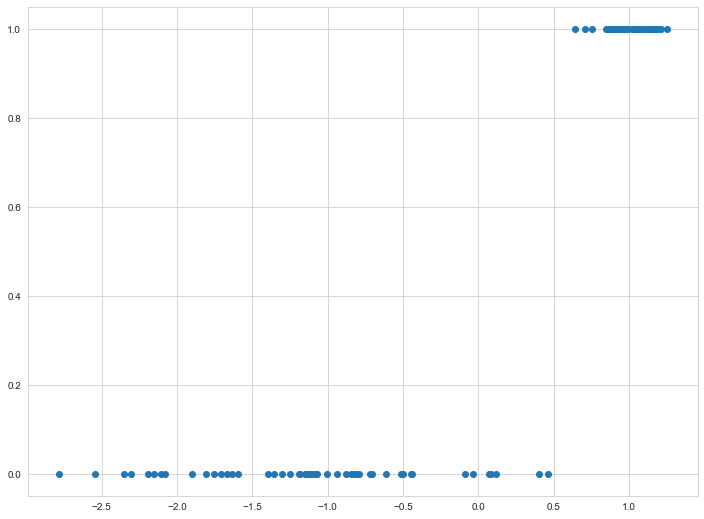

In [109]:
plt.scatter(X, y);

In [110]:
custom_log_reg = CustomLogisticRegression()
custom_log_reg.fit(X, y)
y_pred = custom_log_reg.predict(X)

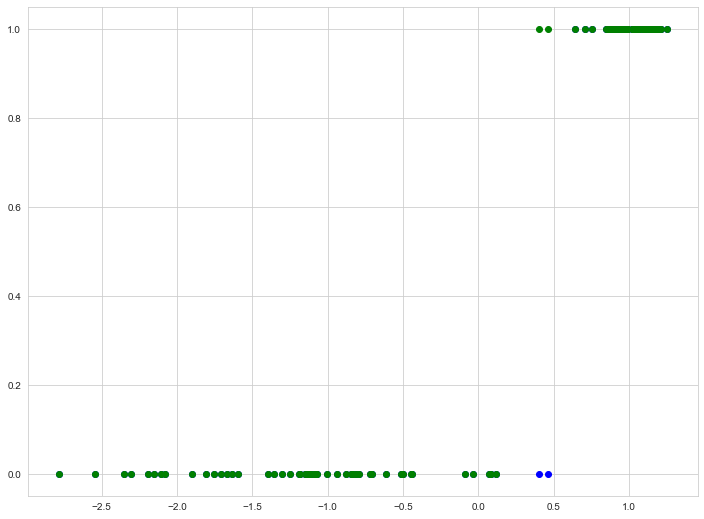

In [111]:
plt.scatter(X, y, color='b')
plt.scatter(X, y_pred, color='g');

Проверьте качество работы модели при помощи известных вам метрик бинарной классификации.

In [112]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
precision_score(y, y_pred), recall_score(y, y_pred), f1_score(y, y_pred), accuracy_score(y, y_pred)

(0.9615384615384616, 1.0, 0.9803921568627451, 0.98)

#### Задание 3.4. Применение логистической регрессии (5 баллов)

Мы будем использовать данные по свойствам покемонов (https://www.kaggle.com/abcsds/pokemon). В данном задании вам необходимо сначала сделать краткий EDA (Посмотреть на данные и их распределения, а также посмотреть, как различные признаки связаны между собой и с целевой переменной (`Legendary`)).

In [145]:
pokemon = pd.read_csv("../data/Pokemon.csv")
pokemon.head()

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False


Мы будем предсказывать является ли покемон легендарным или нет. Замените логическое значение колонки на числовое (перекодировав на 0 и 1). Также подумайте, как в этом случае лучше закодировать категориальные признаки (может быть, лучше их просто выбросить?).

In [164]:
X, y = pokemon.drop('Legendary', axis=1), pokemon['Legendary']

In [165]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y = le.fit_transform(y)

<BarContainer object of 2 artists>

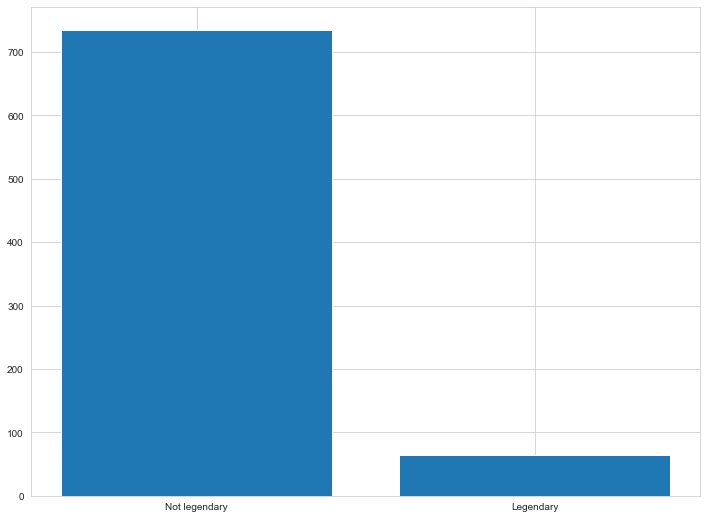

In [166]:
plt.bar(['Not legendary', 'Legendary'], [list(y).count(0), list(y).count(1)])

Наблюдается очень сильный дисбаланс классов

In [167]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 12 columns):
#             800 non-null int64
Name          800 non-null object
Type 1        800 non-null object
Type 2        414 non-null object
Total         800 non-null int64
HP            800 non-null int64
Attack        800 non-null int64
Defense       800 non-null int64
Sp. Atk       800 non-null int64
Sp. Def       800 non-null int64
Speed         800 non-null int64
Generation    800 non-null int64
dtypes: int64(9), object(3)
memory usage: 75.1+ KB


In [168]:
X.std()

#             208.343798
Total         119.963040
HP             25.534669
Attack         32.457366
Defense        31.183501
Sp. Atk        32.722294
Sp. Def        27.828916
Speed          29.060474
Generation      1.661290
dtype: float64

In [169]:
X['Type 2'].count(None)

414

Name скорее всего можно выбросить. Среди Type 2 слишком много NaN, так что наверное тоже лучше выкинуть. # - это, видимо, просто номер строки, так что это тоже лучше выкинуть.

In [170]:
X = X.drop(['#', 'Name', 'Type 2'], axis=1)
X.head()

,Type 1,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation
0,Grass,318,45,49,49,65,65,45,1
1,Grass,405,60,62,63,80,80,60,1
2,Grass,525,80,82,83,100,100,80,1
3,Grass,625,80,100,123,122,120,80,1
4,Fire,309,39,52,43,60,50,65,1


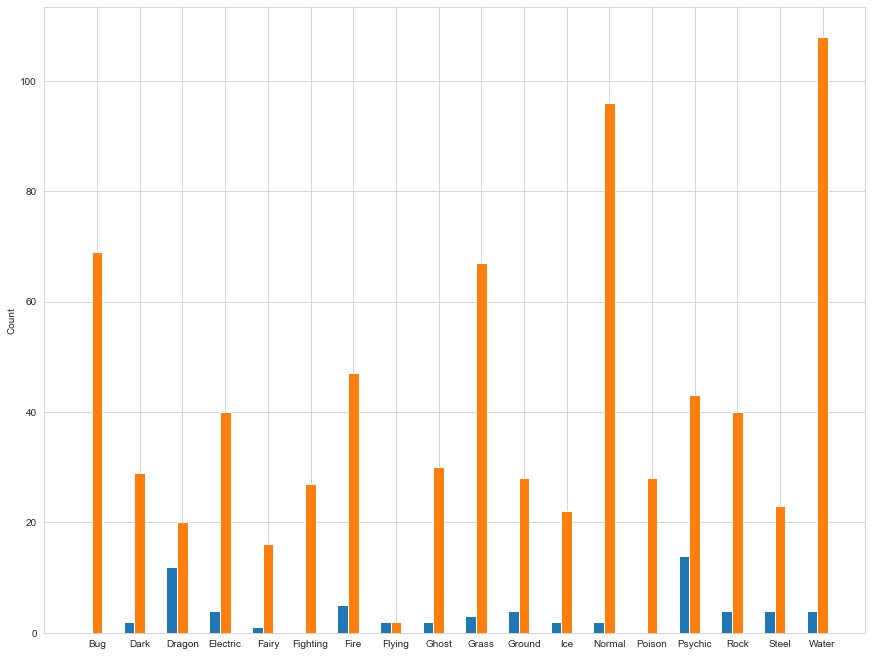

In [192]:
types = np.unique(X['Type 1'])
counts = {'legendary' : [], 'not legendary' : []}
for type in types:
    legendary = 0
    not_legendary = 0
    for i in range(len(X['Type 1'])):
        if X['Type 1'][i] == type:
            if y[i] == 0:
                not_legendary += 1
            else:
                legendary += 1
    counts['legendary'].append(legendary)
    counts['not legendary'].append(not_legendary)

x = np.arange(len(types))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(constrained_layout=True)

for legendarity, count in counts.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, count, width, label=legendarity)
    multiplier += 1


ax.set_ylabel('Count')
x = x + width
plt.xticks(ticks=x, labels=types)

plt.show()

Type 1 надо перекодировать в числовой признак, числовые признаки надо стандартизировать. Добавлю это в пайплайн.

In [193]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

In [203]:
preprocessor = ColumnTransformer([
    ('ohe', OneHotEncoder(sparse=False, drop='first'), ['Type 1']),
    ('standart scaler', StandardScaler(), ['HP',  'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed', 'Generation'])
])

In [204]:
classification_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('logistic regression', LogisticRegression())
])

Разделите ваши данные на тестовую и тренировочную выборку.

In [205]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

Обучите модель `LogisticRegression` из `sklearn`.

In [211]:
classification_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('ohe',
                                                  OneHotEncoder(drop='first',
                                                                sparse=False),
                                                  ['Type 1']),
                                                 ('standart scaler',
                                                  StandardScaler(),
                                                  ['HP', 'Attack', 'Defense',
                                                   'Sp. Atk', 'Sp. Def',
                                                   'Speed', 'Generation'])])),
                ('logistic regression', LogisticRegression())])

In [212]:
y_pred = classification_pipeline.predict(X_test)

Выведите метрики вашего классификатора:

1. Нарисуйте [confusion matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html).

2. Изобразите ROC кривую и посчитайте площадь под ней.

3. Скажите, какие признаки оказались наиболее важны для модели.

In [213]:
f1_score(y_test, y_pred)

0.6428571428571428

In [242]:
from sklearn.metrics import ConfusionMatrixDisplay, roc_curve, roc_auc_score

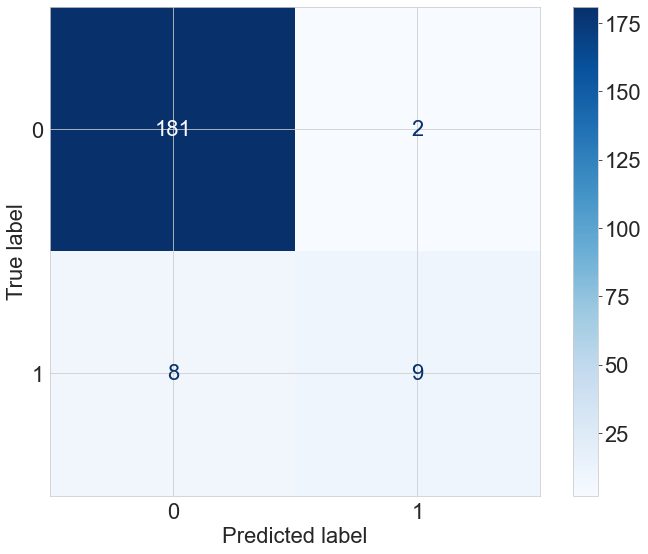

In [233]:
matrix = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred))
matrix.plot(cmap=plt.cm.Blues)
plt.rcParams.update({'font.size': 30})
plt.show()

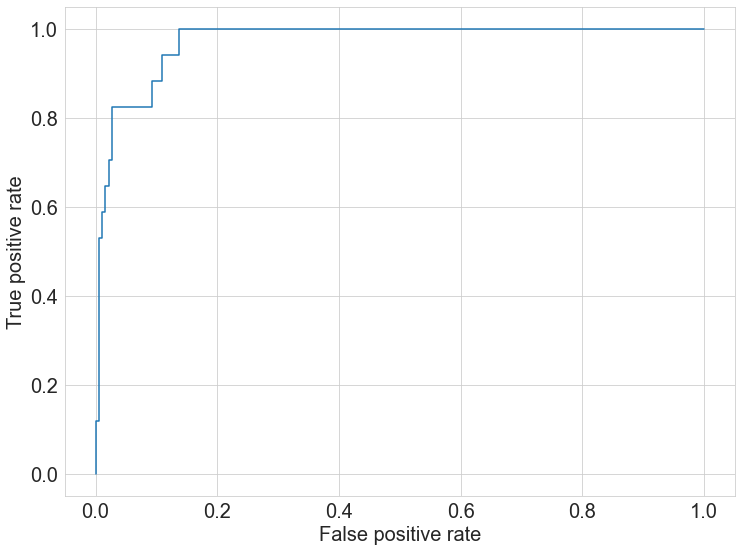

In [240]:
y_prob = classification_pipeline.predict_proba(X_test)
fpr, tpr, threshold = roc_curve(y_test, y_prob[:, 1])

plt.plot(fpr, tpr)
plt.rcParams.update({'font.size': 15})
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

In [243]:
roc_auc_score(y_test,  y_prob[:, 1])

0.971713275474124

In [250]:
pokemons_importance = permutation_importance(classification_pipeline, X_test, y_test,
                            n_repeats=30,
                            random_state=0)

for i in pokemons_importance.importances_mean.argsort()[::-1]:
     print(f"{X.columns.values.tolist()[i]} \t"
              f"{r.importances_mean[i]:.3f}"
              f" +/- {r.importances_std[i]:.3f}")

Sp. Def 	0.020 +/- 0.010
Sp. Atk 	0.020 +/- 0.007
Speed 	0.019 +/- 0.008
HP 	0.012 +/- 0.009
Attack 	0.011 +/- 0.006
Generation 	0.007 +/- 0.007
Defense 	0.005 +/- 0.008
Type 1 	0.001 +/- 0.004
Total 	0.000 +/- 0.000


### Задание 4. Расскажите о вашей любимой музыкальной группе (исполнителе) (0.5 балла)

Расскажите, как вы познакомились с этой группой и скиньте несколько наиболее любимых треков)

Моя любимая группа - System of a Down. В 8 классе моя одноклассница, у которой это любимая группа чуть ли не с рождения, запостила их песни у себя на стеночке. Я тогда уже решила, что я люблю рок, но ещё примерно ничего не знала, кроме самой классики, и решила послушать. Сначала включила Sugar, испугалась, больше не слушала. Потом моя подруга, тоже послушав эти песни из поста одноклассницы, включила мне Radio Video, и я влюбилась. Стала постепенно втягиваться, и вскоре уже Sugar (ну и весь первый альбом, который самый жесткий) мне тоже понравились. Любимые песни - Lonely day (это попса), Aerials, Sad statua, Toxicity, Chop Suey, ATWA, ну в общем почти все...

## Therapy time

Напишите здесь ваши впечатления о задании: было ли интересно, было ли слишком легко или наоборот сложно и тд. Также сюда можно написать свои идеи по улучшению заданий, а также предложить данные, на основе которых вы бы хотели построить следующие дз. 

**Ваши мысли:**

Мне не очень нравится, что мы не особо прошли на паре, что такое ROC curve, и как определять важность параметров (или я это пропустила?). В остальном всё круто. Хотелось бы писать побольше кода самостоятельно.